# Time Series Analysis & Forecasting 📈

**Project Objective:** To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

### Core Concepts:
1.  **Time Series Fundamentals:** Understanding the components of a time series (Trend, Seasonality, Residuals).
2.  **Stationarity:** Learning what stationarity is, why it's crucial for many models, and how to test for it (Augmented Dickey-Fuller test).
3.  **Data Transformation:** Applying techniques like differencing and log transforms to make a series stationary.
4.  **Model Identification:** Using Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots to determine model parameters.
5.  **ARIMA Modeling:** Building a baseline ARIMA model for forecasting.
6.  **SARIMA Modeling:** Extending ARIMA to build a powerful SARIMA model that explicitly handles seasonality.
7.  **Forecasting & Evaluation:** Making predictions and evaluating model performance.

### Step 1: Setup - Importing Libraries and Loading Data

In [1]:
!pip install statsmodels

zsh:1: /Users/eshaagarwal/Code/GeeksForGeeks 21 Projects, 21 Days/venv/bin/pip: bad interpreter: /Users/eshaagarwal/Code/GeeksForGeeks/venv/bin/python3: no such file or directory
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df = pd.read_csv('../Data/airline_passenger_timeseries.csv')
df.shape

(144, 2)

### Step 2: Exploratory Data Analysis & Decomposition

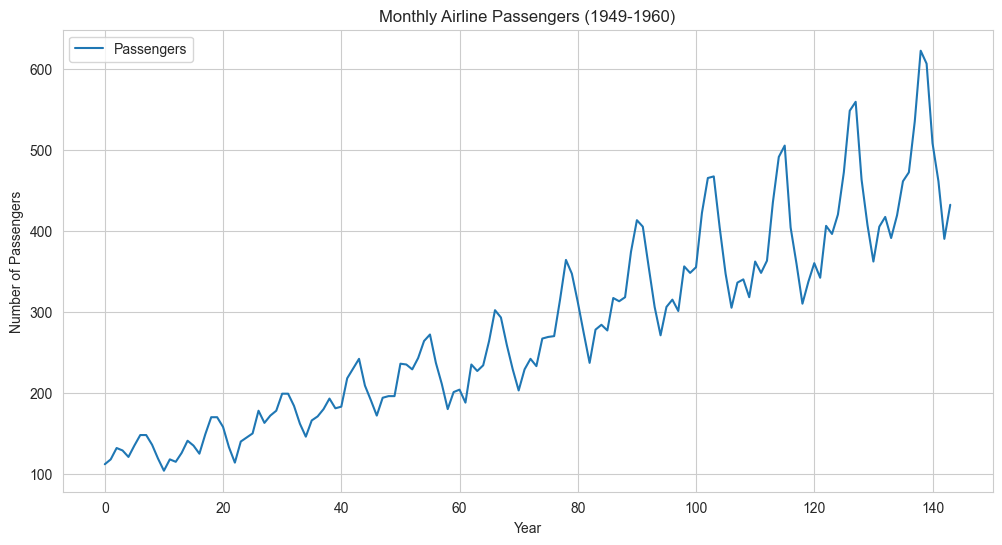

In [4]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

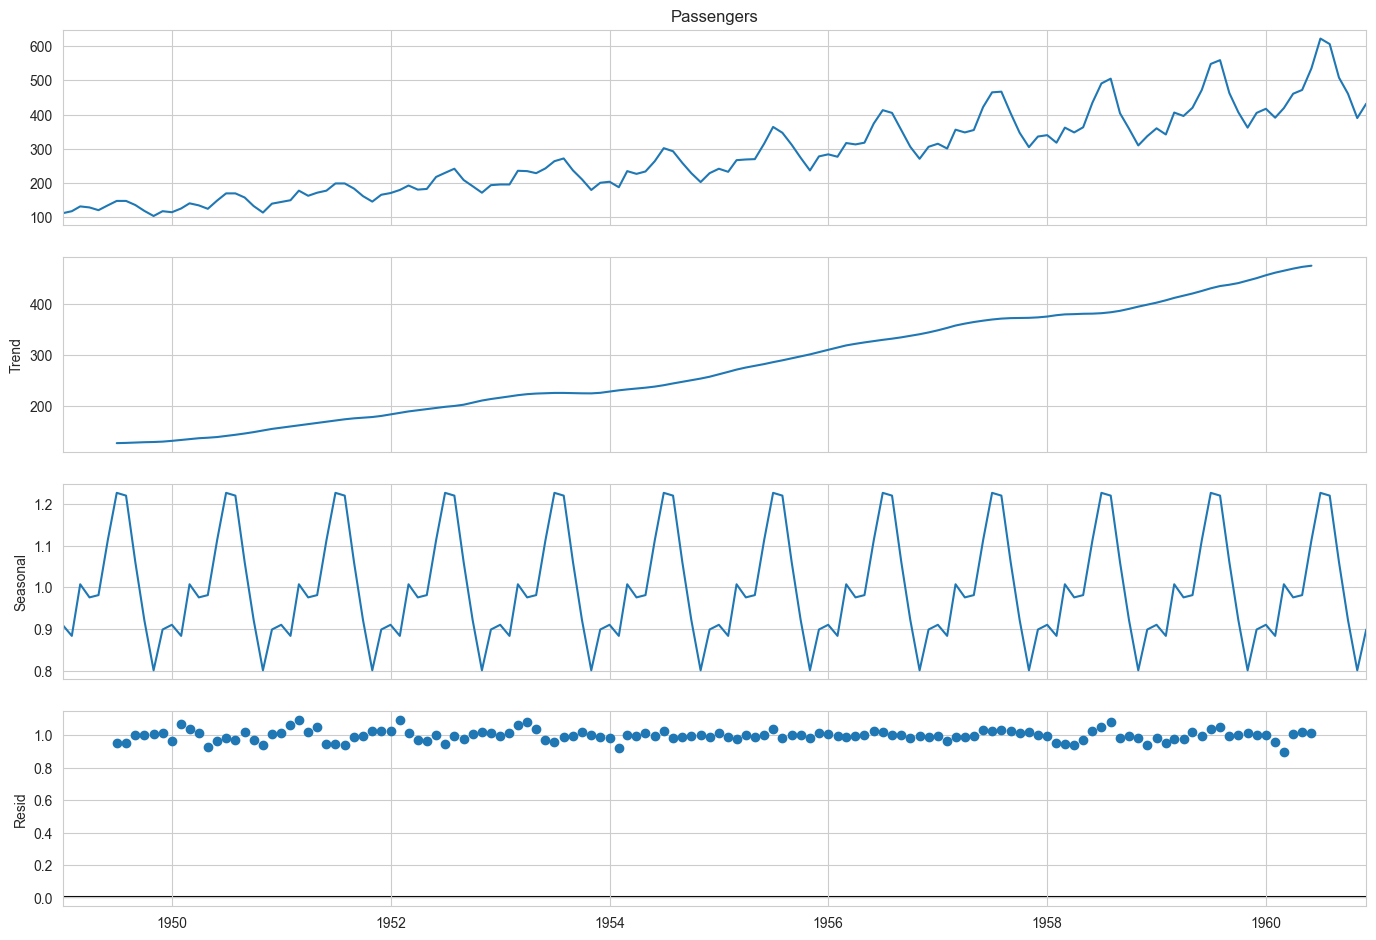

In [5]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### Step 3: Stationarity Testing

#### **Theoretical Concept: Stationarity**
A time series is said to be stationary if its statistical properties:
- **mean**
- **variance**
- **autocorrelation**

are all constant over time.

- **Why is it important?** Stationary series are easier to model and forecast. If a series is stationary, its past behavior is a good predictor of its future behavior. Our passenger data is clearly **non-stationary** because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.

In [6]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


**Result:** The p-value is `0.99`, which is much greater than 0.05. Therefore, we **fail to reject the null hypothesis**. Our data is officially non-stationary, and we need to transform it.

### Step 4: Making the Series Stationary

Applying Log Transformation to induce stationarity

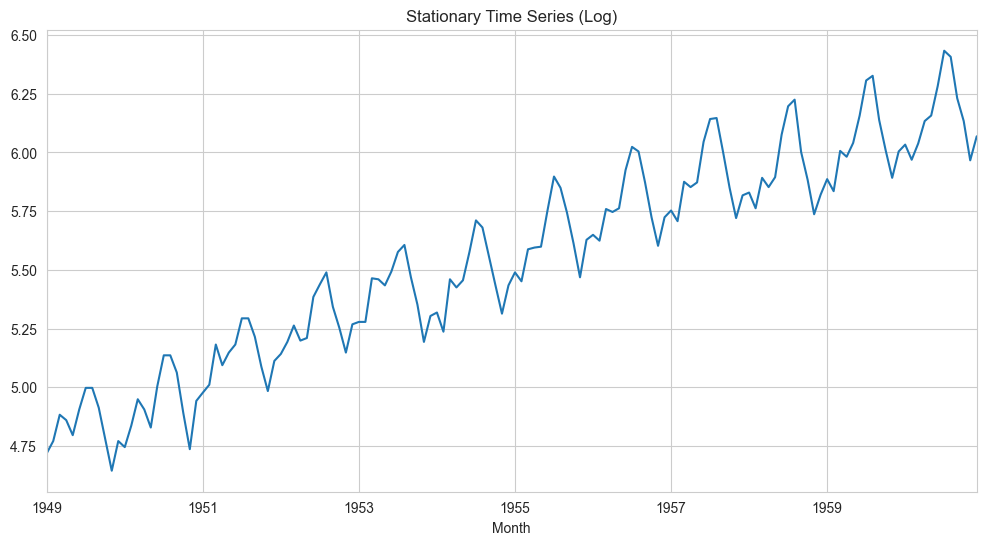

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
df_log = np.log(df['Passengers'])

# Plot the stationary series
df_log.plot()
plt.title('Stationary Time Series (Log)')
plt.show()

# Retest for stationarity
test_stationarity(df_log)

**Result:** The p-value is `0.42`, which is still greater than 0.05. Therefore, we **fail to reject the null hypothesis**. Our data is officially non-stationary, and we need to transform it.

Applying Log Transformation *again* to induce stationarity

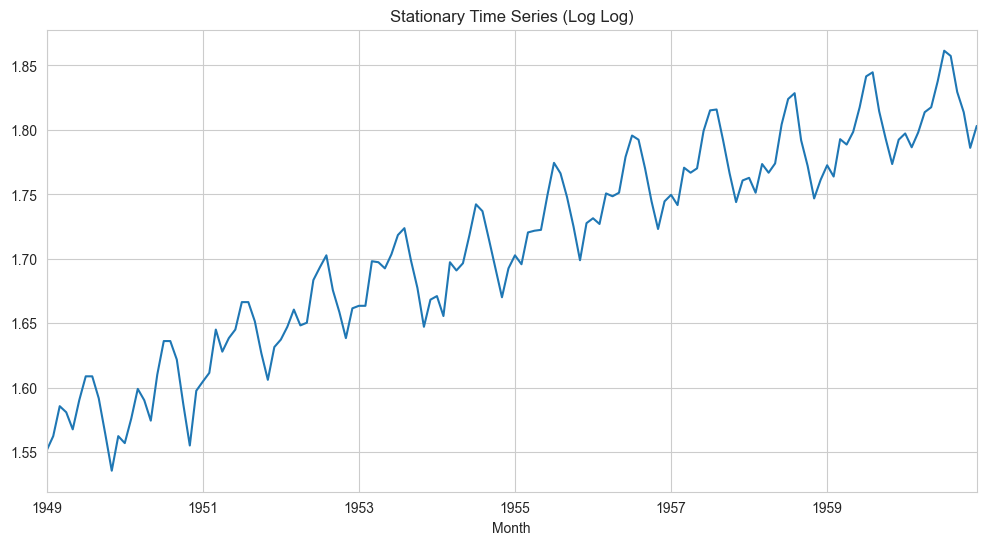

Results of Dickey-Fuller Test:
Test Statistic                  -2.156028
p-value                          0.222590
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
df_log_log = np.log(df_log)

# Plot the stationary series
df_log_log.plot()
plt.title('Stationary Time Series (Log Log)')
plt.show()

# Retest for stationarity
test_stationarity(df_log_log)

**Result:** The p-value is `0.22`, which is still greater than 0.05. Therefore, we **fail to reject the null hypothesis**. Our data is officially non-stationary, and we need to transform it.

Applying seasonal diff instead of log to make stationarity

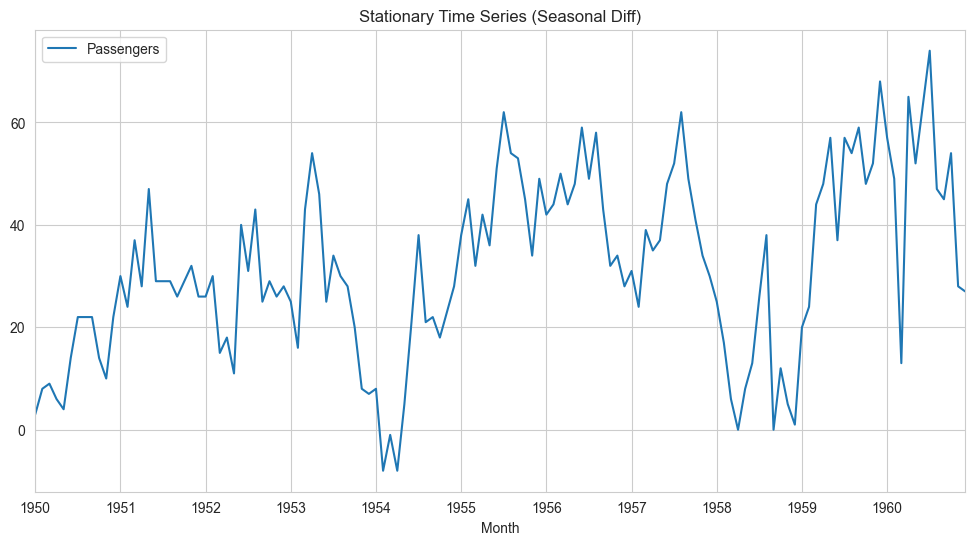

Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
df_seasonal_diff = df.diff(12).dropna()

# Plot the stationary series
df_seasonal_diff.plot()
plt.title('Stationary Time Series (Seasonal Diff)')
plt.show()

# Retest for stationarity
test_stationarity(df_seasonal_diff)

**Result:** The new p-value is `0.01`, which is less than 0.05. We can now **reject the null hypothesis**. Our series is stationary and ready for modeling!

### Step 5: Model Identification with ACF and PACF Plots

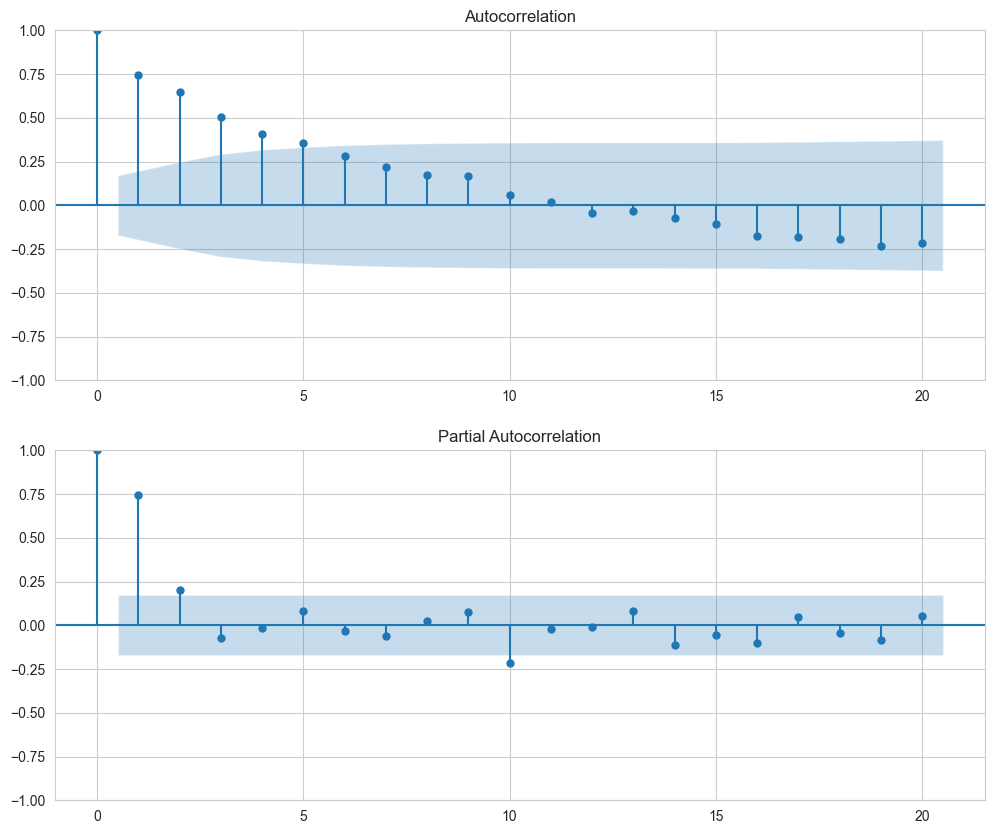

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_seasonal_diff, ax=ax1, lags=20)
plot_pacf(df_seasonal_diff, ax=ax2, lags=20)
plt.show()

**Insights:**

1. `d = 0` for the seasonally differenced series
2. p from PACF plot:
    - p = 1
    - The PACF shows a significant spike at lag 1 (~0.75), then cuts off sharply
3. q from ACF plot:
    - q = 2
    - The ACF shows significant spikes at lags 1 and 2, then gradually declines

## Trying ARIMA on `df_log` data

/Users/eshaagarwal/Code/GeeksForGeeks 21 Projects, 21 Days/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


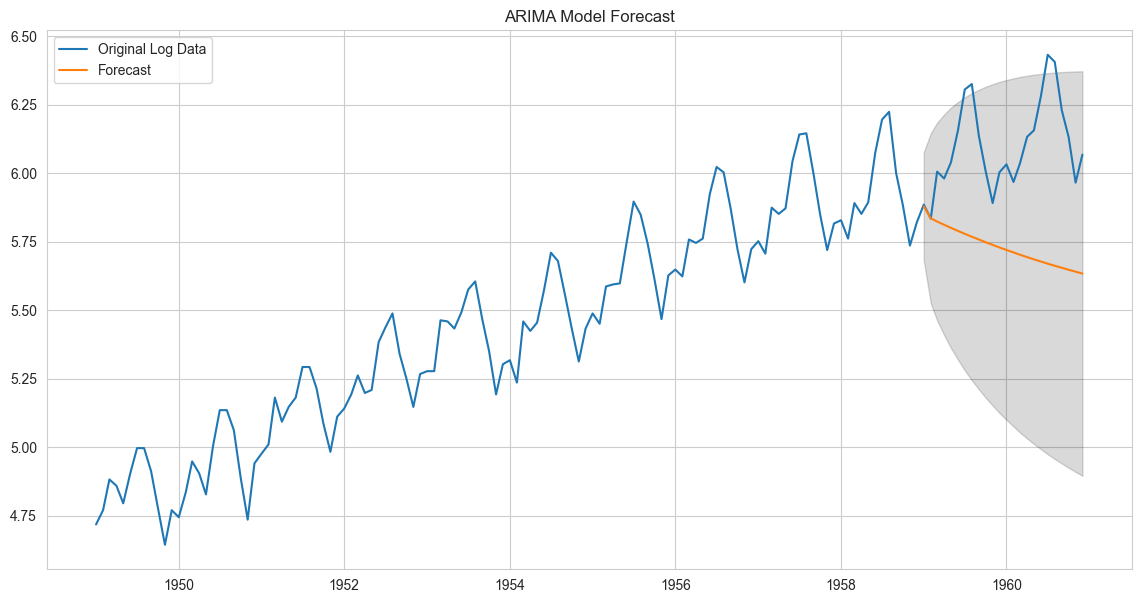

In [11]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 0, 2), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

**ARIMA Result:** The model fails to captures the overall trend and completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

## Trying ARIMA on `df_seasonal_diff` data

/Users/eshaagarwal/Code/GeeksForGeeks 21 Projects, 21 Days/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


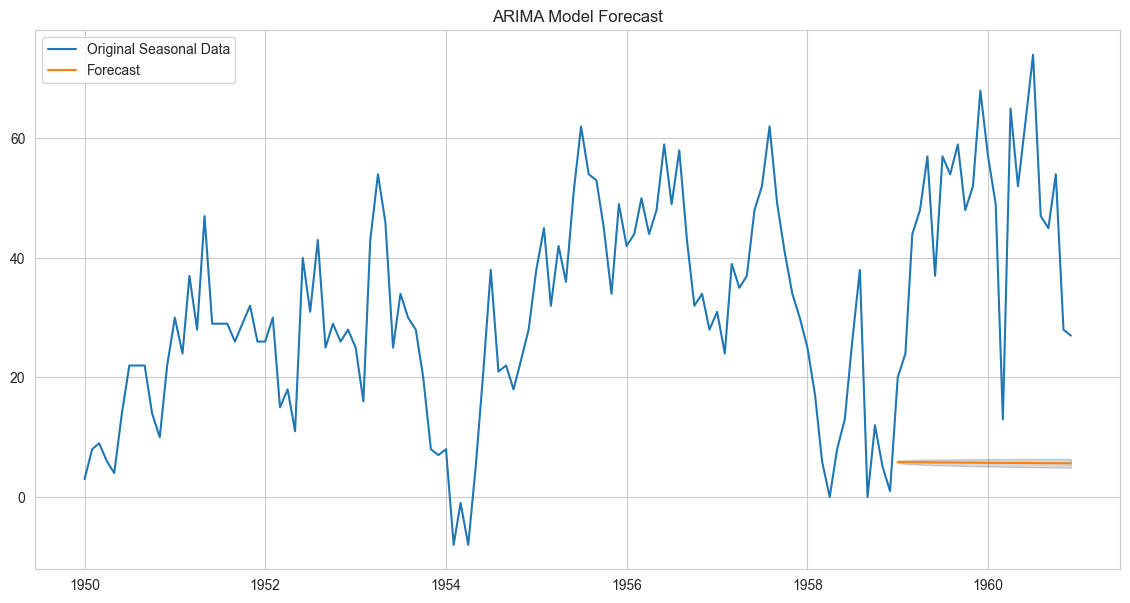

In [12]:
# Split data into training and test sets
train_data_2 = df_seasonal_diff[:'1958']
test_data_2 = df_seasonal_diff['1959':]

# Build ARIMA model
model_2 = ARIMA(train_data_2, order=(1, 0, 2), freq='MS')
arima_result_2 = model_2.fit()

# Get forecast
forecast_2 = arima_result.get_forecast(steps=len(test_data_2))
forecast_ci_2 = forecast_2.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_seasonal_diff, label='Original Seasonal Data')
plt.plot(forecast_2.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci_2.index, forecast_ci_2.iloc[:, 0], forecast_ci_2.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

**ARIMA Result:** The model fails to captures the overall trend and completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

### Step 7: Building a SARIMA Model for Seasonality

/Users/eshaagarwal/Code/GeeksForGeeks 21 Projects, 21 Days/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


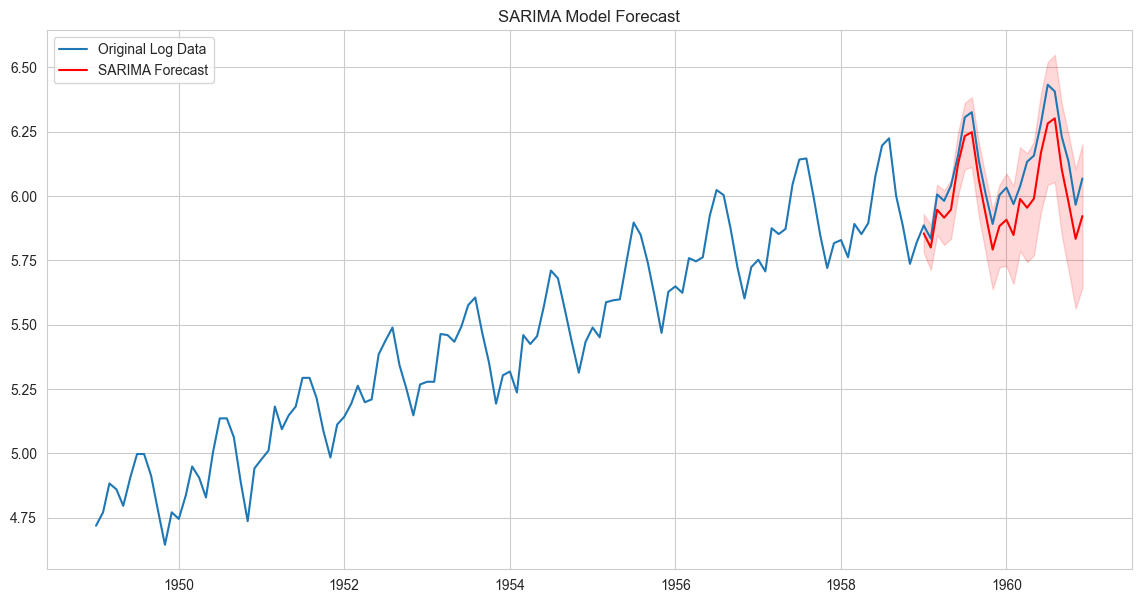

In [13]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(
    train_data,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
    freq="MS",
)  # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label="Original Log Data")
plt.plot(sarima_forecast.predicted_mean, label="SARIMA Forecast", color="red")
plt.fill_between(
    sarima_forecast_ci.index,
    sarima_forecast_ci.iloc[:, 0],
    sarima_forecast_ci.iloc[:, 1],
    color="r",
    alpha=0.15,
)
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()

### Step 8: Final Evaluation

MAE: 43.77
MSE: 2331.45
RMSE: 48.29


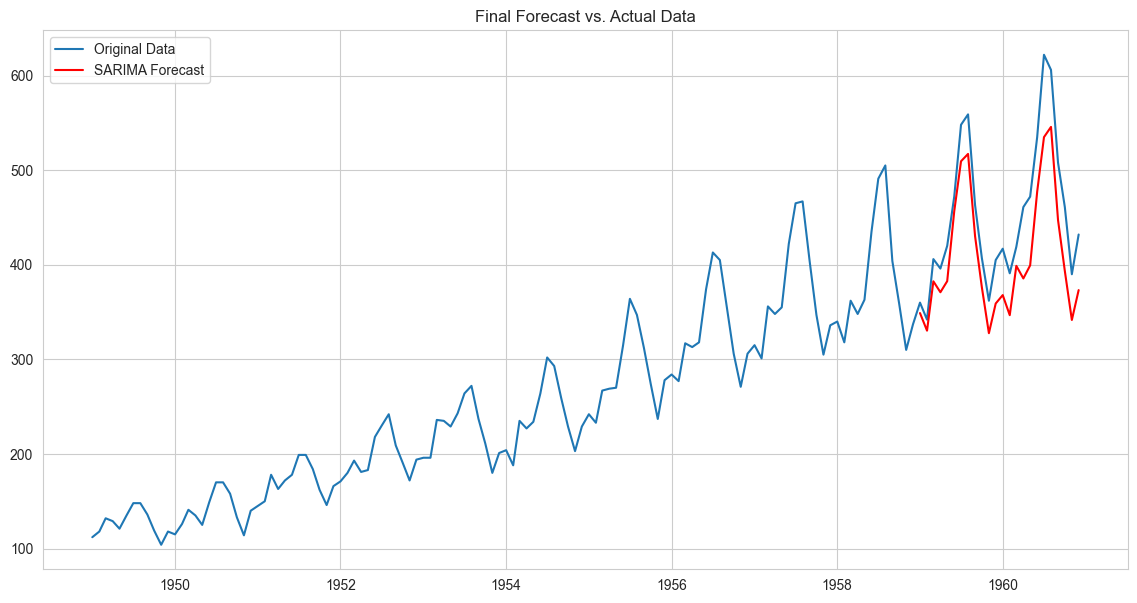

In [14]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Evaluate model performance
mae = mean_absolute_error(original_test_data, sarima_predictions)
mse = mean_squared_error(original_test_data, sarima_predictions)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

### Step 9: Conclusion

In this project, we built a complete time series forecasting pipeline.

**Key Steps Undertaken:**
1.  **Decomposed the time series** to identify its underlying trend and strong yearly seasonality.
2.  **Confirmed non-stationarity** using the Augmented Dickey-Fuller test.
3.  **Transformed the data** using log transforms and differencing to achieve stationarity, a prerequisite for ARIMA modeling.
4.  **Used ACF/PACF plots** to identify the initial parameters for our model.
5.  **Built a baseline ARIMA model** which captured the trend but failed to model the seasonality.
6.  **Built an advanced SARIMA model** that successfully captured both trend and seasonality, resulting in a much more accurate forecast.
7.  **Evaluated the final model** on the original scale using MAE, MSE, RMSE.

This project clearly demonstrates the importance of identifying and specifically modeling seasonality for accurate time series forecasting.